### Importujemy potrzebne biblioteki

In [ ]:
import numpy as np
import pandas as pd
import os
from os import listdir
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Flatten, Activation, Dense, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
image_dir="../input/brain-mri-images-for-brain-tumor-detection/"

In [ ]:
os.makedirs('../output/kaggle/working/augmented-images')
os.makedirs('../output/kaggle/working/augmented-images/yes')
os.makedirs('../output/kaggle/working/augmented-images/no')

In [ ]:
def augment_data(file_dir, n_augments=5, save_to_dir='./augmented'):
    os.makedirs(save_to_dir, exist_ok=True)

    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    for filename in os.listdir(file_dir):
        filepath = os.path.join(file_dir, filename)
        image = cv2.imread(filepath)

        if image is None:
            continue  # pomiń uszkodzone/nieobrazkowe pliki

        image = image.reshape((1,) + image.shape)
        prefix = 'aug_' + os.path.splitext(filename)[0]

        for i, batch in enumerate(datagen.flow(image, batch_size=1, save_to_dir=save_to_dir,
                                                save_prefix=prefix, save_format='jpg')):
            if i >= n_augments:
                break


In [45]:
# Pobieramy dane ze strony: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data w formacie .zip
# Następnie wybieramy pobrany plik

from google.colab import files
#files.upload()  # wybierz plik archive.zip z dysku

In [ ]:
!unzip -q archive.zip -d ./data

In [ ]:
import os
print("Przykładowe obrazy z guzem:", os.listdir('./data/yes')[:5])
print("Przykładowe obrazy bez guza:", os.listdir('./data/no')[:5])

Przykładowe obrazy z guzem: ['Y40.JPG', 'Y154.jpg', 'Y73.jpg', 'Y85.JPG', 'Y58.JPG']
Przykładowe obrazy bez guza: ['no 2.jpg', '10 no.jpg', 'no 98.jpg', 'No18.jpg', 'No22.jpg']


In [ ]:
print("Folder './data/yes':", os.path.exists('./data/yes'))
print("Folder './data/no':", os.path.exists('./data/no'))


Folder './data/yes': True
Folder './data/no': True


In [ ]:
# Główna ścieżka do oryginalnych obrazów
image_dir = './data/'

# Ścieżka do zapisu augmentowanych danych
augmented_data_path = './augmented/'

# Utwórz foldery, jeśli jeszcze nie istnieją
os.makedirs(os.path.join(augmented_data_path, 'yes'), exist_ok=True)
os.makedirs(os.path.join(augmented_data_path, 'no'), exist_ok=True)

# Dla obrazów z guzem
augment_data(
    file_dir=os.path.join(image_dir, 'yes'),
    n_augments=6,
    save_to_dir=os.path.join(augmented_data_path, 'yes')
)

# Dla obrazów bez guza
augment_data(
    file_dir=os.path.join(image_dir, 'no'),
    n_augments=9,
    save_to_dir=os.path.join(augmented_data_path, 'no')
)

In [ ]:
def crop_brain_contour(image, plot=False):

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

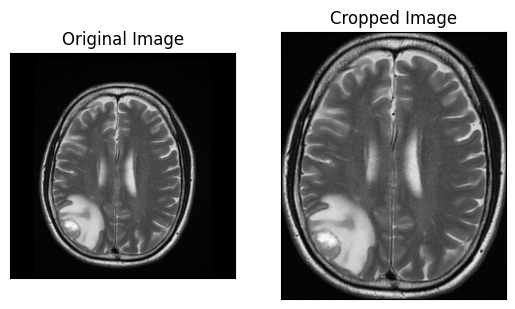

In [ ]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y

In [ ]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


In [ ]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2):
    # Podziel na 80% treningowe i 20% testowe + walidacyjne
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size, random_state=42)

    # Z tej 20% podziel na 50% testowe i 50% walidacyjne (czyli 10% na test i 10% na walidację)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, random_state=42)

    return X_train, y_train, X_val, y_val, X_test, y_test

# Wywołanie z nowym podziałem
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.2)


In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))


number of training examples = 1651
number of validation examples = 207
number of test examples = 206


In [ ]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid')(X)
    model = Model(inputs = X_input, outputs = X)

    return model


In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

Epoch 1/22
52/52 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.5741 - loss: 1.0330 - val_accuracy: 0.7053 - val_loss: 0.6354
Epoch 2/22
52/52 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.7532 - loss: 0.5104 - val_accuracy: 0.7778 - val_loss: 0.5818
Epoch 3/22
52/52 ━━━━━━━━━━━━━━━━━━━━ 200s 4s/step - accuracy: 0.8210 - loss: 0.4146 - val_accuracy: 0.6763 - val_loss: 0.5638
Epoch 4/22
52/52 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.8054 - loss: 0.3928 - val_accuracy: 0.7681 - val_loss: 0.5085
Epoch 5/22
52/52 ━━━━━━━━━━━━━━━━━━━━ 203s 4s/step - accuracy: 0.8599 - loss: 0.3507 - val_accuracy: 0.8019 - val_loss: 0.4396
Epoch 6/22
52/52 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - accuracy: 0.8895 - loss: 0.2845 - val_accuracy: 0.7198 - val_loss: 0.4914
Epoch 7/22
52/52 ━━━━━━━━━━━━━━━━━━━━ 202s 4s/step - accuracy: 0.8841 - loss: 0.2882 - val_accuracy: 0.8164 - val_loss: 0.3899
Epoch 8/22
52/52 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - accuracy: 0.8943 - loss: 0.2562 - val_accuracy: 0.8357 - v

In [ ]:
# ~1h 10min

In [ ]:
history = model.history.history

In [ ]:
def plot_metrics(history):

    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']

    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

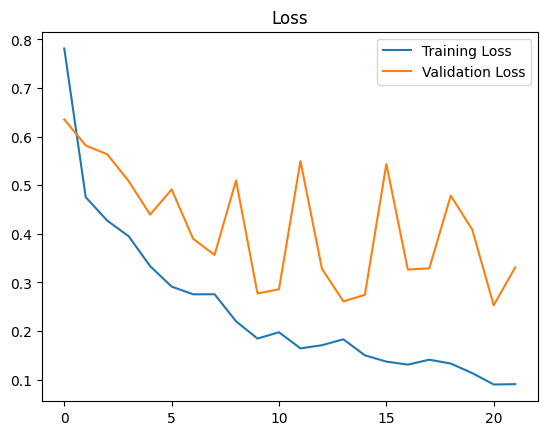

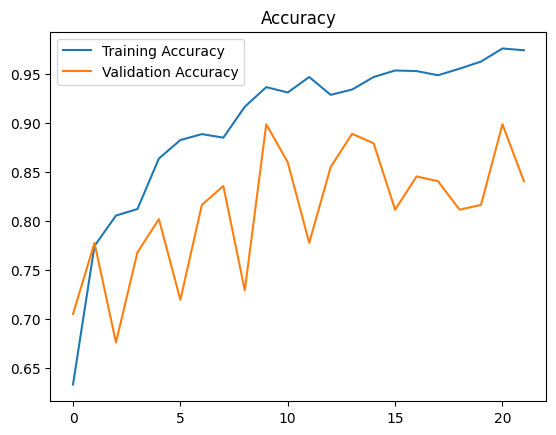

In [ ]:
plot_metrics(history)


In [ ]:
model.save('brain_tumor_detector.h5')

In [ ]:
model.save('brain_tumor_detector.keras')